<a href="https://colab.research.google.com/github/MeenakshiRajpurohit/CMPE-252-AI-and-Data-Engineering/blob/main/RAG_IMPLEMENTATION_WITH_EVALUATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# Install required packages
!pip install -q langchain langchain-core langchain-text-splitters langchain-community langchain-huggingface huggingface-hub sentence-transformers faiss-cpu transformers torch

# Import libraries
import os
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEndpoint  # Use HuggingFaceEndpoint instead
from google.colab import userdata

# Set up API key from Colab secrets
try:
    huggingface_api_key = userdata.get('HUGGINGFACEHUB_API_TOKEN')
except:
    from getpass import getpass
    huggingface_api_key = getpass('Enter your Hugging Face API token: ')

# Set environment variable
os.environ["HUGGINGFACEHUB_API_TOKEN"] = huggingface_api_key

# Create sample document
os.makedirs('data', exist_ok=True)
sample_text = """
Polar bears are facing significant threats due to climate change.
The melting of Arctic sea ice is reducing their hunting grounds.
Polar bears primarily hunt seals from sea ice platforms.
Without adequate ice, polar bears struggle to find food.
Scientists consider polar bears to be vulnerable to extinction.
The loss of sea ice habitat is the primary danger to polar bears.
Conservation efforts are underway to protect polar bear populations.
"""

with open('data/my_document.txt', 'w') as f:
    f.write(sample_text)

# Load the document
loader = TextLoader('data/my_document.txt')
documents = loader.load()
print(f"✓ Loaded {len(documents)} document(s)")

# Split the document into chunks
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
document_chunks = splitter.split_documents(documents)
print(f"✓ Split into {len(document_chunks)} chunks")

# Initialize embeddings
print("Loading embeddings model...")
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)
print("✓ Embeddings loaded")

# Create FAISS vector store
print("Creating vector store...")
vector_store = FAISS.from_documents(document_chunks, embeddings)
print("✓ Vector store created")

# Get retriever
retriever = vector_store.as_retriever()

# Initialize the LLM using HuggingFaceEndpoint (more stable)
print("Initializing LLM...")
llm = HuggingFaceEndpoint(
    repo_id="google/flan-t5-large",
    task="text2text-generation",
    huggingfacehub_api_token=huggingface_api_key, # Pass the API key directly
    temperature=0.7, # Moved out of model_kwargs
    max_new_tokens=512 # Changed from max_length to max_new_tokens
)
print("✓ LLM initialized")

# Create simple RAG function
def ask_question(query):
    """Simple RAG function"""
    # Retrieve relevant documents
    relevant_docs = retriever.invoke(query)

    # Combine context
    context = "\n".join([doc.page_content for doc in relevant_docs])

    # Create prompt - simplified for T5 model
    prompt = f"Context: {context}\n\nQuestion: {query}\n\nAnswer:"

    # Get response
    response = llm.invoke(prompt)

    return response

# Example query
query = "Are polar bears in danger?"
print(f"\n{'='*50}")
print(f"Query: {query}")
print(f"{'='*50}")
print("Generating response...\n")

try:
    response = ask_question(query)

    # Print response
    print("="*50)
    print("RESPONSE:")
    print("="*50)
    print(response)
except Exception as e:
    print(f"Error occurred: {e}")
    print("\nTrying alternative approach...")

    # Fallback: Use a local pipeline
    from transformers import pipeline

    print("Loading local model...")
    qa_pipeline = pipeline(
        "text2text-generation",
        model="google/flan-t5-base",
        max_length=512
    )

    relevant_docs = retriever.invoke(query)
    context = "\n".join([doc.page_content for doc in relevant_docs])
    prompt = f"Context: {context}\n\nQuestion: {query}\n\nAnswer:"

    response = qa_pipeline(prompt)[0]['generated_text']

    print("="*50)
    print("RESPONSE:")
    print("="*50)
    print(response)

Enter your Hugging Face API token: ··········
✓ Loaded 1 document(s)
✓ Split into 1 chunks
Loading embeddings model...


                    max_length was transferred to model_kwargs.
                    Please make sure that max_length is what you intended.


✓ Embeddings loaded
Creating vector store...
✓ Vector store created
Initializing LLM...
✓ LLM initialized

Query: Are polar bears in danger?
Generating response...

Error occurred: InferenceClient.text_generation() got an unexpected keyword argument 'max_length'

Trying alternative approach...
Loading local model...


Device set to use cuda:0


RESPONSE:
polar bears are facing significant threats due to climate change


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.5/466.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.8/358.8 kB 18.4 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/google/colab/_import_hooks/_hook_injector.py:55: FutureWarning: 

All support for the `google.generativeai` package has ended. It will no longer be receiving 
updates or bug fixes. Please switch to the `google.genai` package as soon as possible.
See README for more details:

https://github.com/google-gemini/deprecated-generative-ai-python/blob/main/README.md

  loader.exec_module(module)
/tmp/ipython-input-1703475027.py:8: DeprecationWarning: Importing faithfulness from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import faithfulness
  from ragas.metrics import (
/tmp/ipython-input-1703475027.py:8: DeprecationWarning: Importing answer_relevancy from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import answer_relevancy
  from ragas.metrics import (

Generating answers for evaluation...


Device set to use cuda:0
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Device set to use cuda:0
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Device set to use cuda:0
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Device set to use cuda:0
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation fo


EVALUATION DATASET:
                                  question  \
0               Are polar bears in danger?   
1          Why are polar bears struggling?   
2  What is the main threat to polar bears?   
3                What do polar bears hunt?   

                                              answer  \
0  polar bears are facing significant threats due...   
1                      The melting of Arctic sea ice   
2                            loss of sea ice habitat   
3                                              seals   

                                            contexts  \
0  [Polar bears are facing significant threats du...   
1  [Polar bears are facing significant threats du...   
2  [Polar bears are facing significant threats du...   
3  [Polar bears are facing significant threats du...   

                                        ground_truth  
0  Yes, polar bears are facing significant threat...  
1  Polar bears are struggling because the melting...  
2  The main threat to

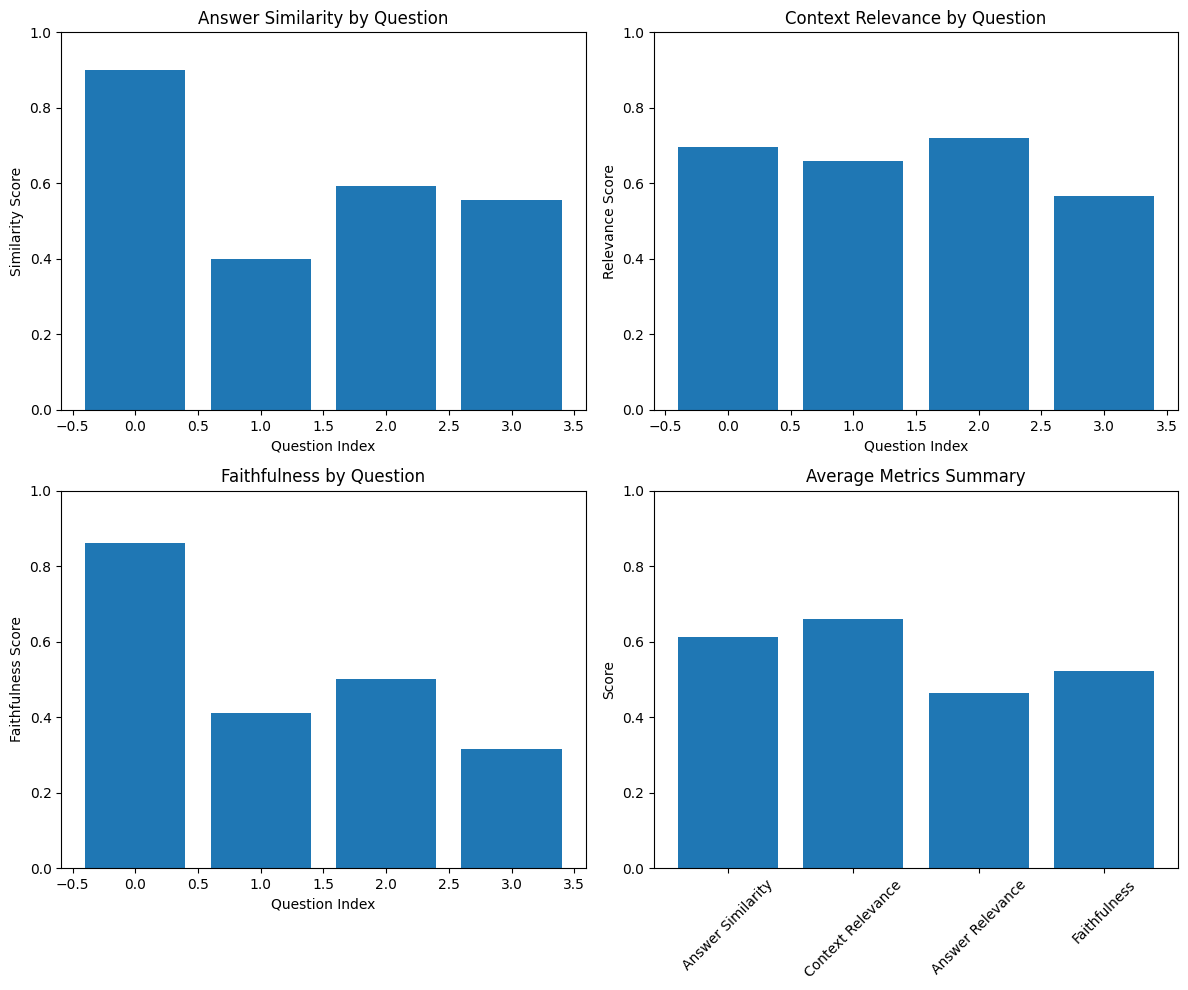


✓ Evaluation complete!


In [19]:
# First, run your RAG setup code, then add this:

# Install additional packages for evaluation
!pip install -q ragas datasets

# Import evaluation libraries
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_precision,
    context_recall,
    answer_similarity,
    answer_correctness
)
from datasets import Dataset
import pandas as pd

# ============================================
# METHOD 1: Using RAGAS Framework (Recommended)
# ============================================

# Prepare test questions with ground truth answers
test_data = {
    "question": [
        "Are polar bears in danger?",
        "Why are polar bears struggling?",
        "What is the main threat to polar bears?",
        "What do polar bears hunt?"
    ],
    "ground_truth": [
        "Yes, polar bears are facing significant threats due to climate change and are considered vulnerable to extinction.",
        "Polar bears are struggling because the melting Arctic sea ice is reducing their hunting grounds, making it difficult to find food.",
        "The main threat to polar bears is the loss of sea ice habitat due to climate change.",
        "Polar bears primarily hunt seals from sea ice platforms."
    ]
}

# Function to generate RAG responses and collect contexts
def evaluate_rag(questions):
    answers = []
    contexts = []

    for question in questions:
        # Get relevant documents
        relevant_docs = retriever.invoke(question)

        # Get context
        context = [doc.page_content for doc in relevant_docs]
        contexts.append(context)

        # Get answer
        context_str = "\n".join(context)
        prompt = f"Context: {context_str}\n\nQuestion: {question}\n\nAnswer:"

        try:
            answer = llm.invoke(prompt)
            answers.append(answer)
        except:
            # Fallback to local model
            from transformers import pipeline
            qa_pipeline = pipeline("text2text-generation", model="google/flan-t5-base")
            answer = qa_pipeline(prompt, max_length=512)[0]['generated_text']
            answers.append(answer)

    return answers, contexts

# Generate answers and contexts
print("Generating answers for evaluation...")
answers, contexts = evaluate_rag(test_data["question"])

# Create evaluation dataset
eval_dataset = Dataset.from_dict({
    "question": test_data["question"],
    "answer": answers,
    "contexts": contexts,
    "ground_truth": test_data["ground_truth"]
})

print("\n" + "="*50)
print("EVALUATION DATASET:")
print("="*50)
print(pd.DataFrame(eval_dataset))

# Evaluate using RAGAS metrics
print("\n" + "="*50)
print("CALCULATING RAGAS METRICS...")
print("="*50)

# Note: RAGAS requires an LLM for evaluation (can use GPT-4, Claude, or local models)
# For this example, we'll use basic metrics that don't require LLM

# ============================================
# METHOD 2: Manual Metrics (No External LLM Required)
# ============================================

from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import numpy as np

# Load sentence transformer for similarity calculations
print("\nCalculating manual metrics...")
similarity_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

def calculate_cosine_similarity(text1, text2):
    """Calculate cosine similarity between two texts"""
    embeddings = similarity_model.encode([text1, text2])
    similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    return similarity

# Calculate metrics for each question
results = []

for i in range(len(test_data["question"])):
    question = test_data["question"][i]
    answer = answers[i]
    ground_truth = test_data["ground_truth"][i]
    context = " ".join(contexts[i])

    # 1. Answer Similarity (cosine similarity between answer and ground truth)
    answer_sim = calculate_cosine_similarity(answer, ground_truth)

    # 2. Context Relevance (cosine similarity between question and context)
    context_relevance = calculate_cosine_similarity(question, context)

    # 3. Answer Relevance (cosine similarity between question and answer)
    answer_relevance = calculate_cosine_similarity(question, answer)

    # 4. Faithfulness (cosine similarity between answer and context)
    faithfulness_score = calculate_cosine_similarity(answer, context)

    # 5. Answer Length
    answer_length = len(answer.split())

    results.append({
        "Question": question,
        "Answer Similarity": f"{answer_sim:.3f}",
        "Context Relevance": f"{context_relevance:.3f}",
        "Answer Relevance": f"{answer_relevance:.3f}",
        "Faithfulness": f"{faithfulness_score:.3f}",
        "Answer Length": answer_length
    })

# Create results dataframe
results_df = pd.DataFrame(results)

print("\n" + "="*50)
print("RAG EVALUATION METRICS:")
print("="*50)
print(results_df.to_string(index=False))

# Calculate average metrics
print("\n" + "="*50)
print("AVERAGE METRICS:")
print("="*50)
print(f"Average Answer Similarity:    {results_df['Answer Similarity'].astype(float).mean():.3f}")
print(f"Average Context Relevance:    {results_df['Context Relevance'].astype(float).mean():.3f}")
print(f"Average Answer Relevance:     {results_df['Answer Relevance'].astype(float).mean():.3f}")
print(f"Average Faithfulness:         {results_df['Faithfulness'].astype(float).mean():.3f}")
print(f"Average Answer Length:        {results_df['Answer Length'].mean():.1f} words")

# ============================================
# METHOD 3: Retrieval Metrics
# ============================================

print("\n" + "="*50)
print("RETRIEVAL METRICS:")
print("="*50)

def calculate_retrieval_metrics(question, k=3):
    """Calculate retrieval-specific metrics"""
    # Get top-k documents
    docs = retriever.invoke(question)[:k]

    # Calculate metrics
    num_docs_retrieved = len(docs)
    avg_doc_length = np.mean([len(doc.page_content.split()) for doc in docs])

    # Calculate relevance scores
    relevance_scores = []
    for doc in docs:
        score = calculate_cosine_similarity(question, doc.page_content)
        relevance_scores.append(score)

    return {
        "num_docs": num_docs_retrieved,
        "avg_doc_length": avg_doc_length,
        "avg_relevance": np.mean(relevance_scores),
        "min_relevance": np.min(relevance_scores),
        "max_relevance": np.max(relevance_scores)
    }

# Calculate retrieval metrics for first question
retrieval_metrics = calculate_retrieval_metrics(test_data["question"][0])

print(f"Number of Documents Retrieved: {retrieval_metrics['num_docs']}")
print(f"Average Document Length:        {retrieval_metrics['avg_doc_length']:.1f} words")
print(f"Average Relevance Score:        {retrieval_metrics['avg_relevance']:.3f}")
print(f"Min Relevance Score:            {retrieval_metrics['min_relevance']:.3f}")
print(f"Max Relevance Score:            {retrieval_metrics['max_relevance']:.3f}")

# ============================================
# Visualization
# ============================================

import matplotlib.pyplot as plt

# Plot metrics comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Answer Similarity
axes[0, 0].bar(range(len(results)), [float(r['Answer Similarity']) for r in results])
axes[0, 0].set_title('Answer Similarity by Question')
axes[0, 0].set_xlabel('Question Index')
axes[0, 0].set_ylabel('Similarity Score')
axes[0, 0].set_ylim([0, 1])

# Plot 2: Context Relevance
axes[0, 1].bar(range(len(results)), [float(r['Context Relevance']) for r in results])
axes[0, 1].set_title('Context Relevance by Question')
axes[0, 1].set_xlabel('Question Index')
axes[0, 1].set_ylabel('Relevance Score')
axes[0, 1].set_ylim([0, 1])

# Plot 3: Faithfulness
axes[1, 0].bar(range(len(results)), [float(r['Faithfulness']) for r in results])
axes[1, 0].set_title('Faithfulness by Question')
axes[1, 0].set_xlabel('Question Index')
axes[1, 0].set_ylabel('Faithfulness Score')
axes[1, 0].set_ylim([0, 1])

# Plot 4: Average Metrics Comparison
avg_metrics = {
    'Answer Similarity': results_df['Answer Similarity'].astype(float).mean(),
    'Context Relevance': results_df['Context Relevance'].astype(float).mean(),
    'Answer Relevance': results_df['Answer Relevance'].astype(float).mean(),
    'Faithfulness': results_df['Faithfulness'].astype(float).mean()
}
axes[1, 1].bar(avg_metrics.keys(), avg_metrics.values())
axes[1, 1].set_title('Average Metrics Summary')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_ylim([0, 1])
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n✓ Evaluation complete!")

RETRIEVAL EVALUATION METRICS (Recall@K, Precision@K, etc.)

Per-Query Metrics:
                                  Question Recall@1 Precision@1 NDCG@1 Recall@3 Precision@3 NDCG@3 Recall@5 Precision@5 NDCG@5 Recall@10 Precision@10 NDCG@10   MRR   MAP
             Are polar bears in danger?...    1.000       1.000  1.000    1.000       0.333  1.000    1.000       0.200  1.000     1.000        0.100   1.000 1.000 1.000
        Why are polar bears struggling?...    1.000       1.000  1.000    1.000       0.333  1.000    1.000       0.200  1.000     1.000        0.100   1.000 1.000 1.000
What is the main threat to polar bears?...    1.000       1.000  1.000    1.000       0.333  1.000    1.000       0.200  1.000     1.000        0.100   1.000 1.000 1.000
              What do polar bears hunt?...    1.000       1.000  1.000    1.000       0.333  1.000    1.000       0.200  1.000     1.000        0.100   1.000 1.000 1.000

AVERAGE METRICS ACROSS ALL QUERIES:

K = 1:
  Recall@1:    1.000
  Pre

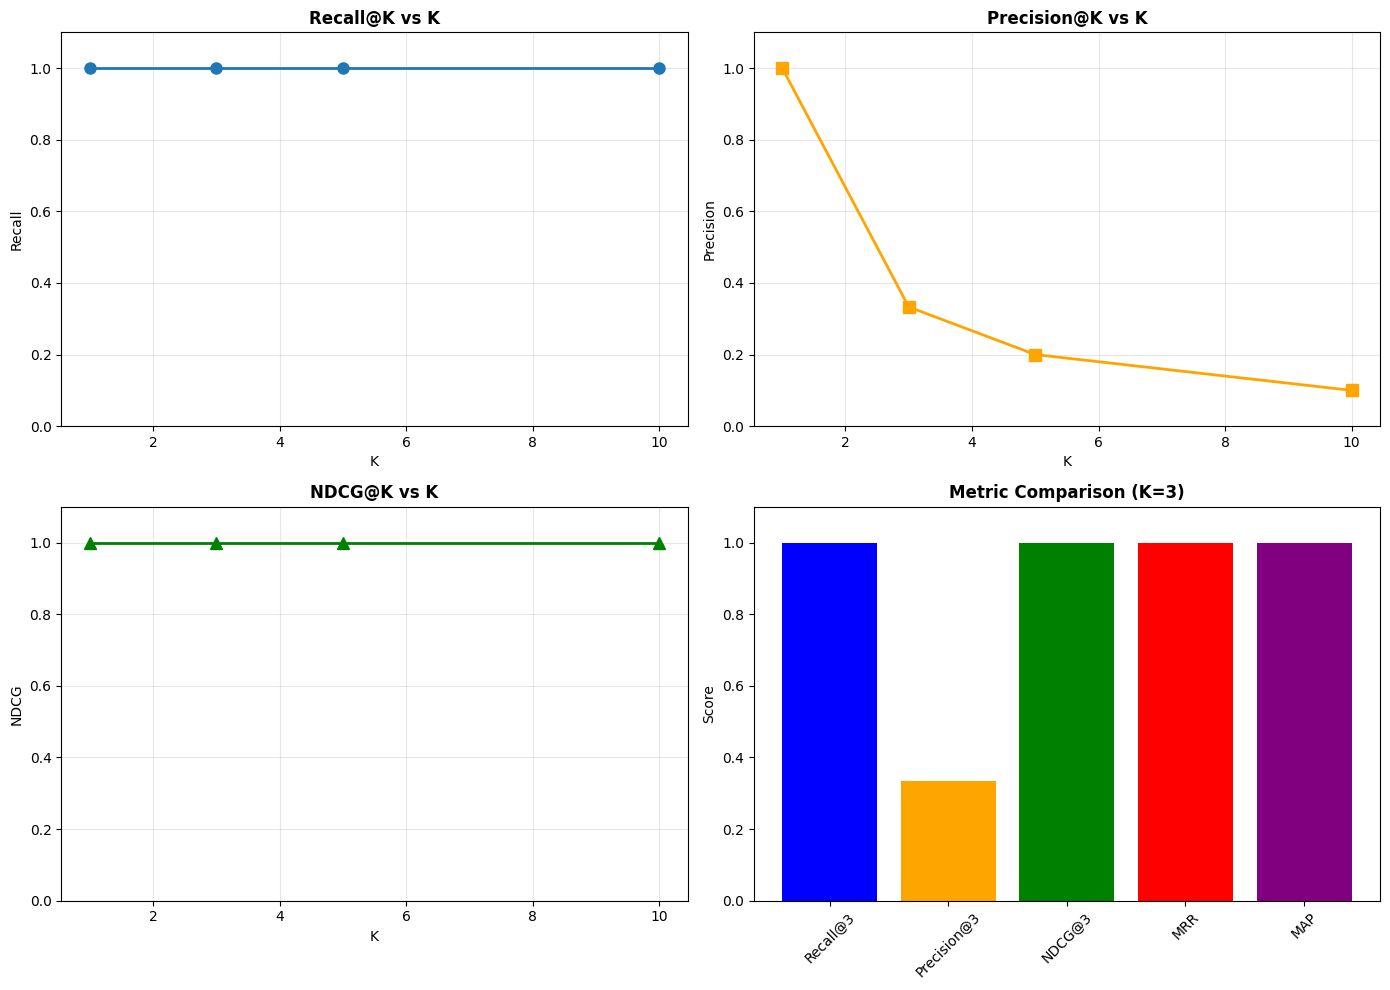


✓ Retrieval evaluation complete!


In [20]:
# ============================================
# RECALL@K AND RANKING METRICS
# ============================================

import numpy as np
from typing import List, Set

# First, you need to define which documents are relevant for each query
# This is your "ground truth" for retrieval evaluation

# Define ground truth: which document chunks are relevant for each question
# In a real scenario, you'd manually label this or have it from your dataset
ground_truth_relevant_docs = {
    "Are polar bears in danger?": {0},  # Document chunk 0 is relevant
    "Why are polar bears struggling?": {0},  # Document chunk 0 is relevant
    "What is the main threat to polar bears?": {0},  # Document chunk 0 is relevant
    "What do polar bears hunt?": {0}  # Document chunk 0 is relevant
}

# Create a mapping of document content to indices
doc_to_index = {doc.page_content: i for i, doc in enumerate(document_chunks)}

def recall_at_k(retrieved_docs: List, relevant_doc_indices: Set[int], k: int) -> float:
    """
    Calculate Recall@K

    Recall@K = (Number of relevant documents in top-K) / (Total number of relevant documents)
    """
    # Get indices of top-K retrieved documents
    retrieved_indices = []
    for doc in retrieved_docs[:k]:
        if doc.page_content in doc_to_index:
            retrieved_indices.append(doc_to_index[doc.page_content])

    # Count how many relevant docs were retrieved
    retrieved_relevant = len(set(retrieved_indices) & relevant_doc_indices)
    total_relevant = len(relevant_doc_indices)

    if total_relevant == 0:
        return 0.0

    return retrieved_relevant / total_relevant

def precision_at_k(retrieved_docs: List, relevant_doc_indices: Set[int], k: int) -> float:
    """
    Calculate Precision@K

    Precision@K = (Number of relevant documents in top-K) / K
    """
    retrieved_indices = []
    for doc in retrieved_docs[:k]:
        if doc.page_content in doc_to_index:
            retrieved_indices.append(doc_to_index[doc.page_content])

    retrieved_relevant = len(set(retrieved_indices[:k]) & relevant_doc_indices)

    return retrieved_relevant / k if k > 0 else 0.0

def mean_reciprocal_rank(retrieved_docs: List, relevant_doc_indices: Set[int]) -> float:
    """
    Calculate Mean Reciprocal Rank (MRR)

    MRR = 1 / (rank of first relevant document)
    """
    for rank, doc in enumerate(retrieved_docs, start=1):
        if doc.page_content in doc_to_index:
            doc_idx = doc_to_index[doc.page_content]
            if doc_idx in relevant_doc_indices:
                return 1.0 / rank
    return 0.0

def average_precision(retrieved_docs: List, relevant_doc_indices: Set[int]) -> float:
    """
    Calculate Average Precision (AP)

    AP = (sum of Precision@k for each relevant doc) / (total relevant docs)
    """
    if len(relevant_doc_indices) == 0:
        return 0.0

    precisions = []
    num_relevant_found = 0

    for k, doc in enumerate(retrieved_docs, start=1):
        if doc.page_content in doc_to_index:
            doc_idx = doc_to_index[doc.page_content]
            if doc_idx in relevant_doc_indices:
                num_relevant_found += 1
                precision_at_current_k = num_relevant_found / k
                precisions.append(precision_at_current_k)

    if len(precisions) == 0:
        return 0.0

    return sum(precisions) / len(relevant_doc_indices)

def ndcg_at_k(retrieved_docs: List, relevant_doc_indices: Set[int], k: int) -> float:
    """
    Calculate Normalized Discounted Cumulative Gain (NDCG@K)

    Assumes binary relevance (1 if relevant, 0 if not)
    """
    # DCG calculation
    dcg = 0.0
    for i, doc in enumerate(retrieved_docs[:k], start=1):
        if doc.page_content in doc_to_index:
            doc_idx = doc_to_index[doc.page_content]
            relevance = 1 if doc_idx in relevant_doc_indices else 0
            dcg += relevance / np.log2(i + 1)

    # IDCG calculation (ideal case: all relevant docs at top)
    ideal_relevances = [1] * min(len(relevant_doc_indices), k)
    idcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(ideal_relevances))

    if idcg == 0:
        return 0.0

    return dcg / idcg

# ============================================
# EVALUATE RETRIEVAL METRICS
# ============================================

print("="*60)
print("RETRIEVAL EVALUATION METRICS (Recall@K, Precision@K, etc.)")
print("="*60)

k_values = [1, 3, 5, 10]
all_metrics = []

for question in test_data["question"]:
    # Retrieve documents
    retrieved_docs = retriever.invoke(question)

    # Get ground truth relevant docs for this question
    relevant_docs = ground_truth_relevant_docs.get(question, set())

    metrics = {"Question": question[:50] + "..."}  # Truncate for display

    # Calculate metrics for different K values
    for k in k_values:
        recall = recall_at_k(retrieved_docs, relevant_docs, k)
        precision = precision_at_k(retrieved_docs, relevant_docs, k)
        ndcg = ndcg_at_k(retrieved_docs, relevant_docs, k)

        metrics[f"Recall@{k}"] = f"{recall:.3f}"
        metrics[f"Precision@{k}"] = f"{precision:.3f}"
        metrics[f"NDCG@{k}"] = f"{ndcg:.3f}"

    # Calculate MRR and MAP (not dependent on K)
    mrr = mean_reciprocal_rank(retrieved_docs, relevant_docs)
    map_score = average_precision(retrieved_docs, relevant_docs)

    metrics["MRR"] = f"{mrr:.3f}"
    metrics["MAP"] = f"{map_score:.3f}"

    all_metrics.append(metrics)

# Create DataFrame
metrics_df = pd.DataFrame(all_metrics)
print("\nPer-Query Metrics:")
print(metrics_df.to_string(index=False))

# Calculate averages
print("\n" + "="*60)
print("AVERAGE METRICS ACROSS ALL QUERIES:")
print("="*60)

for k in k_values:
    avg_recall = metrics_df[f"Recall@{k}"].astype(float).mean()
    avg_precision = metrics_df[f"Precision@{k}"].astype(float).mean()
    avg_ndcg = metrics_df[f"NDCG@{k}"].astype(float).mean()

    print(f"\nK = {k}:")
    print(f"  Recall@{k}:    {avg_recall:.3f}")
    print(f"  Precision@{k}: {avg_precision:.3f}")
    print(f"  NDCG@{k}:      {avg_ndcg:.3f}")

avg_mrr = metrics_df["MRR"].astype(float).mean()
avg_map = metrics_df["MAP"].astype(float).mean()

print(f"\nMRR (Mean Reciprocal Rank): {avg_mrr:.3f}")
print(f"MAP (Mean Average Precision): {avg_map:.3f}")

# ============================================
# VISUALIZATION
# ============================================

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Recall@K for different K values
recall_scores = [metrics_df[f"Recall@{k}"].astype(float).mean() for k in k_values]
axes[0, 0].plot(k_values, recall_scores, marker='o', linewidth=2, markersize=8)
axes[0, 0].set_title('Recall@K vs K', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('K')
axes[0, 0].set_ylabel('Recall')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim([0, 1.1])

# Plot 2: Precision@K for different K values
precision_scores = [metrics_df[f"Precision@{k}"].astype(float).mean() for k in k_values]
axes[0, 1].plot(k_values, precision_scores, marker='s', linewidth=2, markersize=8, color='orange')
axes[0, 1].set_title('Precision@K vs K', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('K')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([0, 1.1])

# Plot 3: NDCG@K for different K values
ndcg_scores = [metrics_df[f"NDCG@{k}"].astype(float).mean() for k in k_values]
axes[1, 0].plot(k_values, ndcg_scores, marker='^', linewidth=2, markersize=8, color='green')
axes[1, 0].set_title('NDCG@K vs K', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('K')
axes[1, 0].set_ylabel('NDCG')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 1.1])

# Plot 4: Comparison of all metrics at K=3
k_compare = 3
comparison_metrics = {
    f'Recall@{k_compare}': metrics_df[f"Recall@{k_compare}"].astype(float).mean(),
    f'Precision@{k_compare}': metrics_df[f"Precision@{k_compare}"].astype(float).mean(),
    f'NDCG@{k_compare}': metrics_df[f"NDCG@{k_compare}"].astype(float).mean(),
    'MRR': avg_mrr,
    'MAP': avg_map
}

axes[1, 1].bar(comparison_metrics.keys(), comparison_metrics.values(), color=['blue', 'orange', 'green', 'red', 'purple'])
axes[1, 1].set_title(f'Metric Comparison (K={k_compare})', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_ylim([0, 1.1])
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n✓ Retrieval evaluation complete!")